In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
import keras
import keras.utils

from sklearn import preprocessing
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

import time
from keras import metrics

MAX_SEQUENCES_LENGTH = 50 # Maximum kata pada kalimat
MAX_NB_WORDS = 20000 # Vocabulary size
EMBEDDING_DIM = 64 # Dimensions of Glove word vector

In [3]:
import json
# load data using Python JSON module
with open('dataset/chatbot_eksyar.json','r') as f:
    data = json.loads(f.read())
    
# Normalizing data
df = pd.json_normalize(data, record_path =['items'])

In [4]:
# Preparing question to X
question = df.questions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(question)
sequences = tokenizer.texts_to_sequences(question)
# Banyak kata yang telah di tokenizer
word_index = tokenizer.word_index

In [5]:
# memasukan hasil tokenizer ke dalam X 
X = pad_sequences(sequences, maxlen=MAX_SEQUENCES_LENGTH, padding='post')

In [6]:
# Preparing Y
# encode label because label alfabetic
# menjadikan label ke kategorikal
le = LabelEncoder()
label = df.labels
labelEncode = le.fit_transform(label)
y = to_categorical(labelEncode)

In [7]:
# bagi data menjadi 2 train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20, stratify=y)

In [8]:
# create model CNN
def build_cnn_model():
    model = Sequential()
    
    model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCES_LENGTH))

    model.add(Conv1D(64, 3, padding='same', activation='relu'))
    # model.add(MaxPooling1D())
    model.add(GlobalMaxPooling1D())
    
    model.add(Flatten())
    
    model.add(Dense(units=250,activation="relu"))  
    model.add(Dense(units=5,activation="softmax"))
    
    model.compile(optimizer="adam",metrics=["accuracy"],loss="categorical_crossentropy")

    model.summary()
    return model

In [9]:
# Train Model
cnn_model = build_cnn_model()
cnn_history = cnn_model.fit(X_train,y_train,epochs=30,validation_data=(X_test, y_test))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 64)            8256      
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 64)            12352     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 250)               16250     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1255      
Total params: 38,113
Trainable params: 38,113
Non-trainable params: 0
____________________________________________________

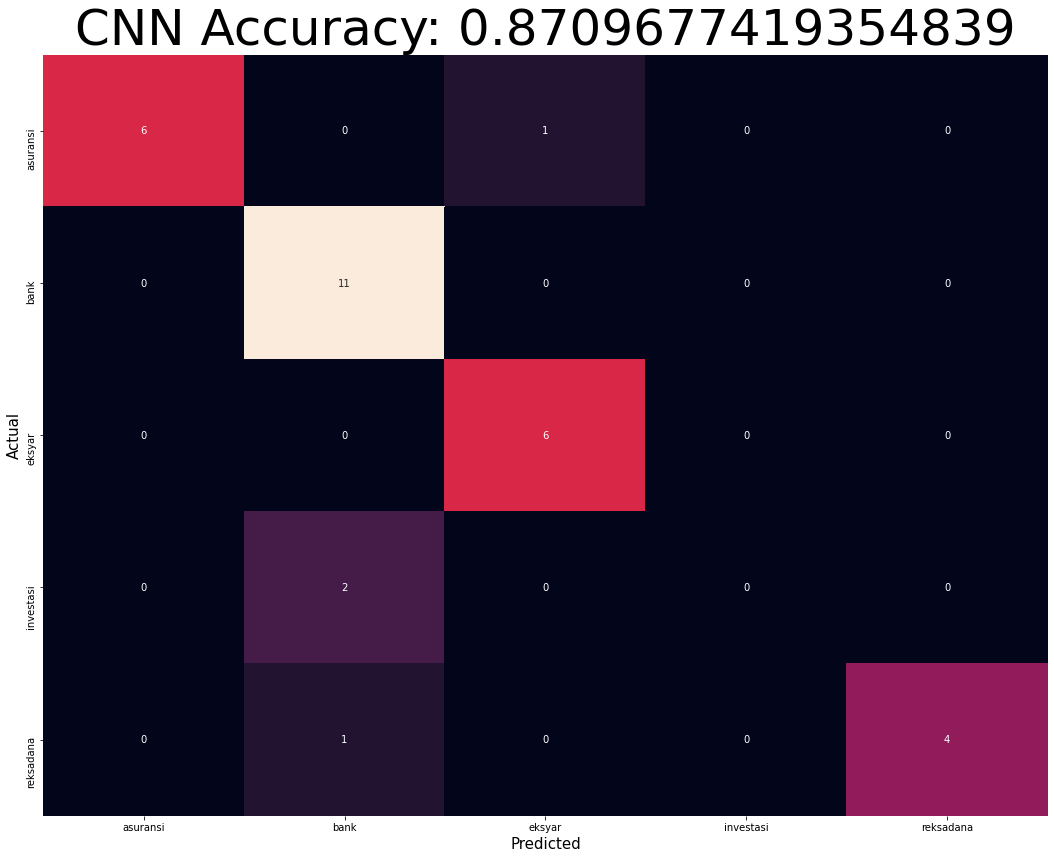

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
ypred = cnn_model.predict(X_test)
cnn_accuracy = accuracy_score(y_test.argmax(axis=-1),ypred.argmax(axis=-1))
#print("CNN Accuracy:",cnn_accuracy)
cnn_cn = confusion_matrix(y_test.argmax(axis=-1),ypred.argmax(axis=-1))
plt.subplots(figsize=(18,14))
sns.heatmap(cnn_cn,annot=True,fmt="1d",cbar=False,xticklabels=le.classes_,yticklabels=le.classes_)
plt.title("CNN Accuracy: {}".format(cnn_accuracy),fontsize=50)
plt.xlabel("Predicted",fontsize=15)
plt.ylabel("Actual",fontsize=15)
plt.show()

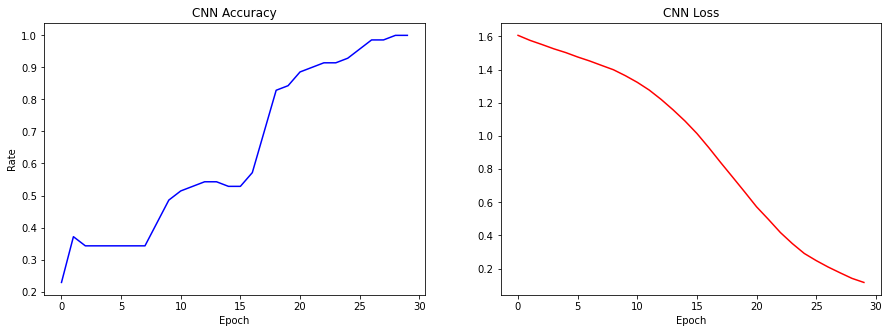

In [11]:
fig3, axe1 = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axe1[0].plot(cnn_history.history["accuracy"],label="accuracy",color="blue")
axe1[1].plot(cnn_history.history["loss"],label="loss",color="red")
axe1[0].title.set_text("CNN Accuracy")
axe1[1].title.set_text("CNN Loss")
axe1[0].set_xlabel("Epoch")
axe1[1].set_xlabel("Epoch")
axe1[0].set_ylabel("Rate")
plt.show()

In [12]:
def cnn_predict(quest):
  puretext = tokenizer.texts_to_sequences(quest)
  text_pad = pad_sequences(puretext,maxlen=50,padding='post')
  predicted = cnn_model.predict(text_pad)
  predicted_category = predicted.argmax(axis=1)
  return le.classes_[predicted_category]

In [13]:
quest = ['apa prinsip-prinsip investasi berdasarkan syariah']
print("CNN Predicted Category: {}".format(cnn_predict(quest)))

CNN Predicted Category: ['investasi']


In [ ]:
# mainin glove dengan metode yang digunakan sekarang dengan cnn 